
# 📊 Telecom X — Churn: EDA Visual + Modelado
Notebook listo para LinkedIn: incluye **extracción/ETL**, **EDA con gráficos**, **modelado (Logística y Random Forest)**, **ROC/PR** y **conclusiones**.


In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['axes.grid'] = True


## 1) Extracción

In [11]:

URL_JSON = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json"

df_raw = pd.read_json(URL_JSON)
df_customer = pd.json_normalize(df_raw['customer'])
df_phone    = pd.json_normalize(df_raw['phone'])
df_internet = pd.json_normalize(df_raw['internet'])
df_account  = pd.json_normalize(df_raw['account'])

df = df_raw[['customerID','Churn']].copy()
df = pd.concat([df, df_account, df_customer, df_internet, df_phone], axis=1)

print("Dim:", df.shape)
df.head(3)


Dim: (7267, 21)


,customerID,Churn,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,gender,SeniorCitizen,Partner,...,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PhoneService,MultipleLines
0,0002-ORFBO,No,One year,Yes,Mailed check,65.6,593.3,Female,0,Yes,...,9,DSL,No,Yes,No,Yes,Yes,No,Yes,No
1,0003-MKNFE,No,Month-to-month,No,Mailed check,59.9,542.4,Male,0,No,...,9,DSL,No,No,No,No,No,Yes,Yes,Yes
2,0004-TLHLJ,Yes,Month-to-month,Yes,Electronic check,73.9,280.85,Male,0,No,...,4,Fiber optic,No,No,Yes,No,No,No,Yes,No


## 2) Transformación (ETL)

In [12]:

# Limpiezas seguras
if 'Charges.Total' in df.columns:
    df.loc[df['Charges.Total'].astype(str).str.strip() == ' ', 'Charges.Total'] = '0'

# Normaliza 'Churn'
if 'Churn' in df.columns:
    s = df['Churn'].astype(str).str.strip().str.lower()
    df.loc[s.isin(['', 'nan', 'none', '0', 'no', 'false']), 'Churn'] = False
    df.loc[s.isin(['1', 'yes', 'true', 'si', 'sí']), 'Churn'] = True

# Filtro de género inválido
if 'gender' in df.columns:
    df = df[df['gender'] != False]

# Casting numérico
for c in ['Charges.Monthly','Charges.Total','SeniorCitizen','tenure']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Feature derivada
if 'Charges.Monthly' in df.columns:
    df['Cuentas_Diarias'] = df['Charges.Monthly'] / 30.0

print(df.info())
df.head(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   Contract          7267 non-null   object 
 3   PaperlessBilling  7267 non-null   object 
 4   PaymentMethod     7267 non-null   object 
 5   Charges.Monthly   7267 non-null   float64
 6   Charges.Total     7256 non-null   float64
 7   gender            7267 non-null   object 
 8   SeniorCitizen     7267 non-null   int64  
 9   Partner           7267 non-null   object 
 10  Dependents        7267 non-null   object 
 11  tenure            7267 non-null   int64  
 12  InternetService   7267 non-null   object 
 13  OnlineSecurity    7267 non-null   object 
 14  OnlineBackup      7267 non-null   object 
 15  DeviceProtection  7267 non-null   object 
 16  TechSupport       7267 non-null   object 


,customerID,Churn,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PhoneService,MultipleLines,Cuentas_Diarias
0,0002-ORFBO,False,One year,Yes,Mailed check,65.6,593.30,Female,0,Yes,...,DSL,No,Yes,No,Yes,Yes,No,Yes,No,2.186667
1,0003-MKNFE,False,Month-to-month,No,Mailed check,59.9,542.40,Male,0,No,...,DSL,No,No,No,No,No,Yes,Yes,Yes,1.996667
2,0004-TLHLJ,True,Month-to-month,Yes,Electronic check,73.9,280.85,Male,0,No,...,Fiber optic,No,No,Yes,No,No,No,Yes,No,2.463333


## 3) EDA — Distribución de Churn

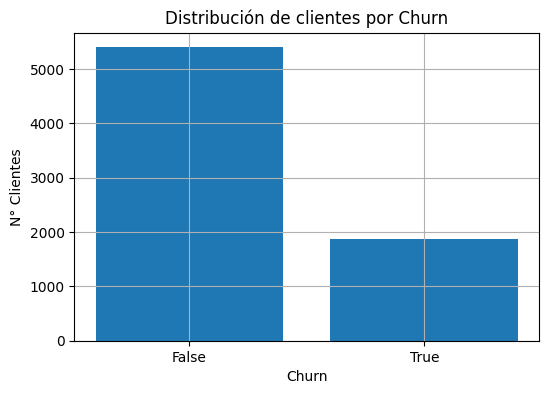

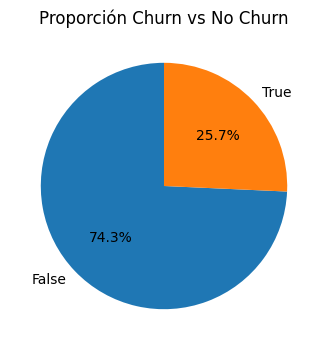

In [13]:

churn_counts = df['Churn'].value_counts(dropna=False)
fig = plt.figure()
plt.bar(churn_counts.index.astype(str), churn_counts.values)
plt.title("Distribución de clientes por Churn")
plt.xlabel("Churn")
plt.ylabel("N° Clientes")
plt.show()

fig = plt.figure()
sizes = churn_counts.values
labels = churn_counts.index.astype(str)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Proporción Churn vs No Churn")
plt.show()


### 3.1 Categóricas vs Churn (proporciones)

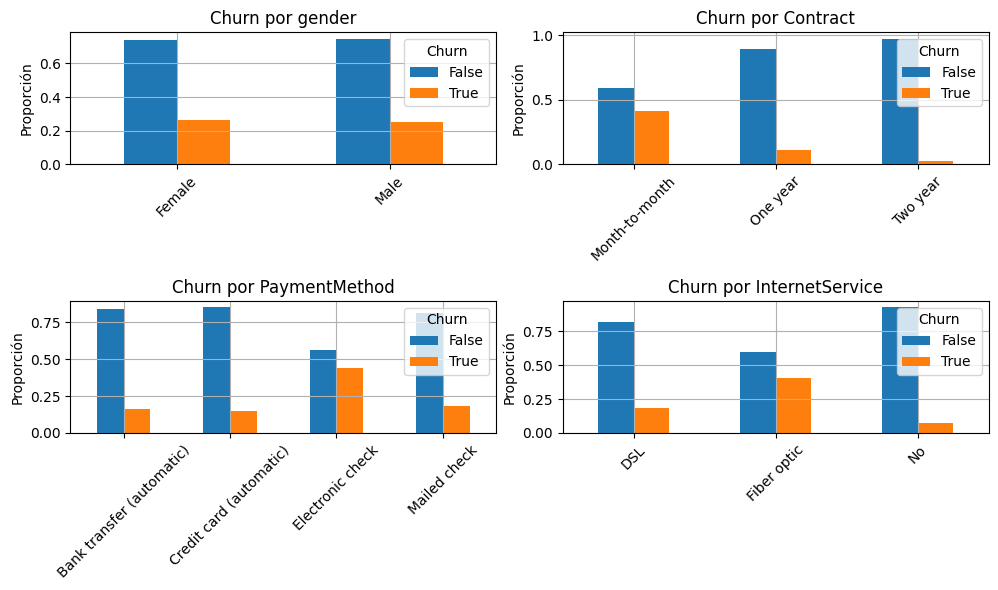

In [14]:

categoricas = [c for c in ['gender','Contract','PaymentMethod','InternetService'] if c in df.columns]
n = min(4, len(categoricas))
rows = 2
cols = 2
fig_count = 0

fig, axes = plt.subplots(rows, cols, figsize=(10,6))
axes = axes.flatten()

for i, var in enumerate(categoricas[:rows*cols]):
    prop = (df.groupby(var)['Churn'].value_counts(normalize=True)
              .rename('Proporción')
              .reset_index())
    piv = prop.pivot(index=var, columns='Churn', values='Proporción').fillna(0.0)
    ax = axes[i]
    piv.plot(kind='bar', ax=ax, legend=True)
    ax.set_title(f"Churn por {var}")
    ax.set_xlabel("")
    ax.set_ylabel("Proporción")
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


### 3.2 Numéricas vs Churn (boxplots)

C:\Users\carlo\AppData\Local\Temp\ipykernel_6468\844053443.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data0, data1], labels=['No Churn','Churn'], showfliers=False)
C:\Users\carlo\AppData\Local\Temp\ipykernel_6468\844053443.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data0, data1], labels=['No Churn','Churn'], showfliers=False)
C:\Users\carlo\AppData\Local\Temp\ipykernel_6468\844053443.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([data0, data1], labels=['No Churn','Churn'], showfliers=False)


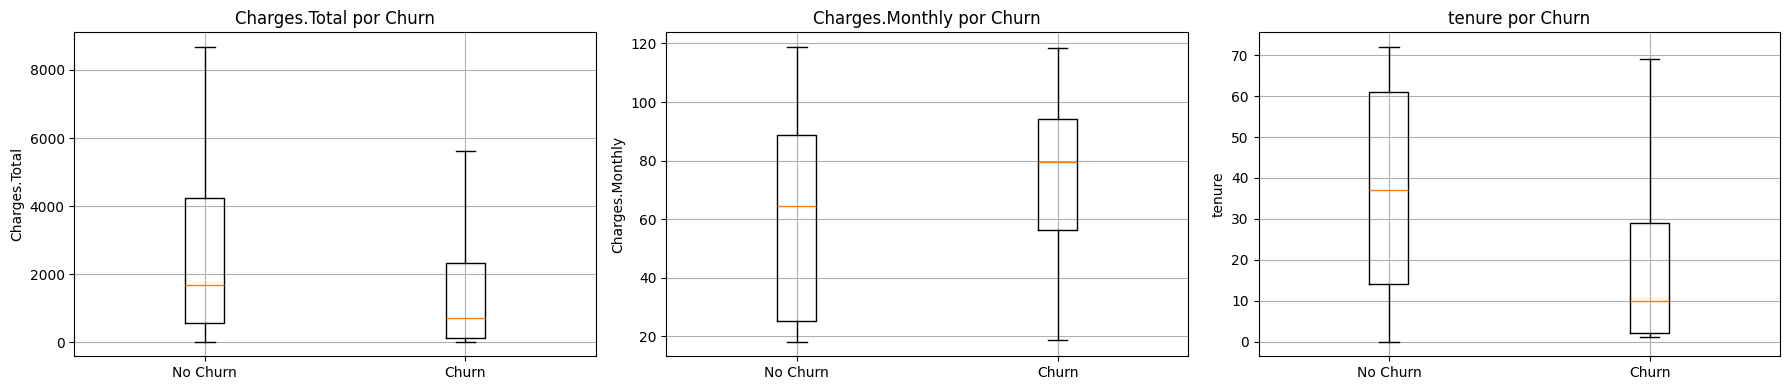

In [15]:

numericas = [c for c in ['Charges.Total','Charges.Monthly','tenure'] if c in df.columns]

if len(numericas) > 0:
    fig, axes = plt.subplots(1, len(numericas), figsize=(6*len(numericas),4))
    if len(numericas) == 1:
        axes = [axes]
    for i, var in enumerate(numericas):
        ax = axes[i]
        data0 = df.loc[df['Churn']==False, var].dropna()
        data1 = df.loc[df['Churn']==True, var].dropna()
        ax.boxplot([data0, data1], labels=['No Churn','Churn'], showfliers=False)
        ax.set_title(f"{var} por Churn")
        ax.set_ylabel(var)
    plt.tight_layout()
    plt.show()


### 3.3 Dispersión: Charges.Monthly vs Charges.Total (color = Churn)

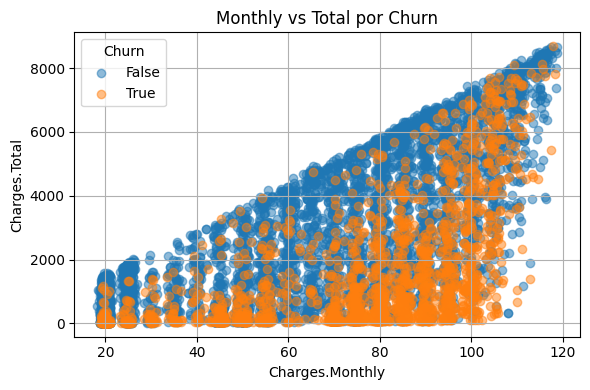

In [16]:

if {'Charges.Monthly','Charges.Total','Churn'}.issubset(df.columns):
    subset = df.dropna(subset=['Charges.Monthly','Charges.Total','Churn'])
    fig = plt.figure()
    for label in [False, True]:
        d = subset[subset['Churn']==label]
        plt.scatter(d['Charges.Monthly'], d['Charges.Total'], alpha=0.5, label=str(label))
    plt.legend(title="Churn")
    plt.xlabel("Charges.Monthly")
    plt.ylabel("Charges.Total")
    plt.title("Monthly vs Total por Churn")
    plt.tight_layout()
    plt.show()


## 4) Matriz de correlación (numéricas)

C:\Users\carlo\AppData\Local\Temp\ipykernel_6468\374927177.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_corr['Servicios_Contratados'] = df_corr[serv_cols].applymap(lambda v: 1 if v is True else 0).sum(axis=1)


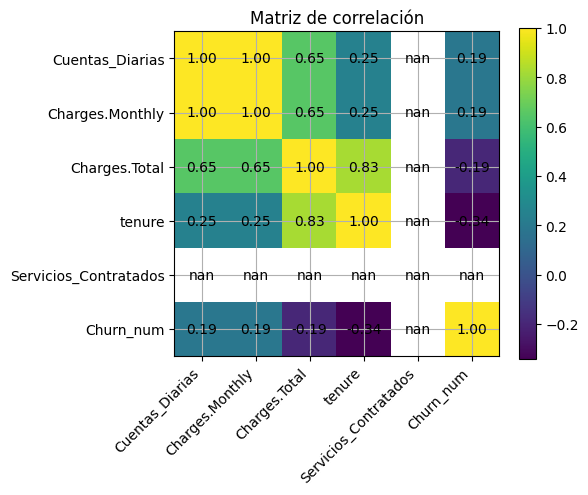

In [17]:

# Preparar target numérico
df_corr = df.copy()
df_corr['Churn_num'] = df_corr['Churn'].map({True:1, False:0})

serv_cols = [c for c in ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport",
                         "StreamingTV","StreamingMovies","PhoneService","MultipleLines"]
             if c in df_corr.columns]
if serv_cols:
    df_corr['Servicios_Contratados'] = df_corr[serv_cols].applymap(lambda v: 1 if v is True else 0).sum(axis=1)

cols_num = [c for c in ['Cuentas_Diarias','Charges.Monthly','Charges.Total','tenure','Servicios_Contratados','Churn_num'] if c in df_corr.columns]
corr = df_corr[cols_num].corr()

fig = plt.figure(figsize=(6,5))
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(cols_num)), cols_num, rotation=45, ha='right')
plt.yticks(range(len(cols_num)), cols_num)
for i in range(len(cols_num)):
    for j in range(len(cols_num)):
        plt.text(j, i, f"{corr.iloc[i,j]:.2f}", ha='center', va='center')
plt.title("Matriz de correlación")
plt.colorbar()
plt.tight_layout()
plt.show()


## 5) Modelado (OHE, split, Logística y Random Forest)

In [18]:

# Preparación para ML
df_model = df.copy()
if 'customerID' in df_model.columns:
    df_model = df_model.drop(columns=['customerID'])

# Target 0/1
df_model['Churn'] = df_model['Churn'].map({True:1, False:0}).astype(int)

# One-hot encoding
cat_cols = df_model.select_dtypes(include=['object']).columns.tolist()
df_model = pd.get_dummies(df_model, columns=cat_cols, drop_first=True)

# Split
# ⛑️ Sanitizar valores infinitos y preparar para imputación
X = df_model.drop(columns=['Churn'])
y = df_model['Churn']

# Reemplazar ±inf por NaN para que el imputador los trate
X = X.replace([np.inf, -np.inf], np.nan)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
# Modelos
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

# Pipelines con imputación (median) para TODOS los modelos
pipe_log = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, random_state=42))
])

pipe_knn = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(n_neighbors=15, weights='distance'))
])

pipe_svm = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LinearSVC(random_state=42, max_iter=5000, dual=False))
])

# Random Forest no requiere escalado, pero sí imputación
pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
])

# Entrenamiento
pipe_log.fit(X_train, y_train)
pipe_knn.fit(X_train, y_train)
pipe_svm.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

# Predicciones
y_pred_log = pipe_log.predict(X_test)
y_pred_knn = pipe_knn.predict(X_test)
y_pred_svm = pipe_svm.predict(X_test)
y_pred_rf  = pipe_rf.predict(X_test)


### 5.1 Matrices de confusión

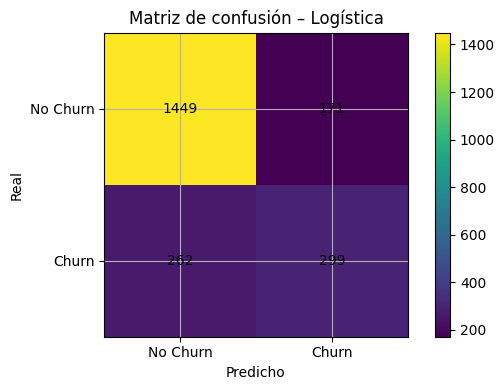

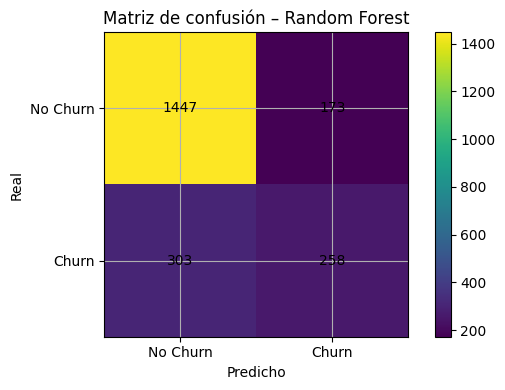

In [19]:

from sklearn.metrics import confusion_matrix
import numpy as np

def plot_cm(cm, title):
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ['No Churn','Churn'])
    plt.yticks(ticks, ['No Churn','Churn'])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i,j], 'd'), ha='center', va='center')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()

cm_log = confusion_matrix(y_test, y_pred_log)
cm_rf  = confusion_matrix(y_test, y_pred_rf)

plot_cm(cm_log, "Matriz de confusión – Logística")
plot_cm(cm_rf,  "Matriz de confusión – Random Forest")


### 5.2 Curvas ROC y Precision-Recall (AUC/AP)

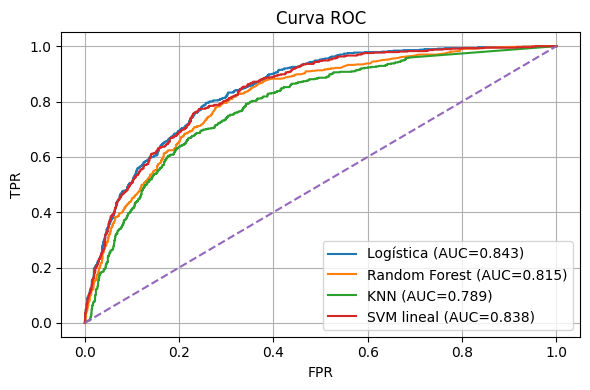

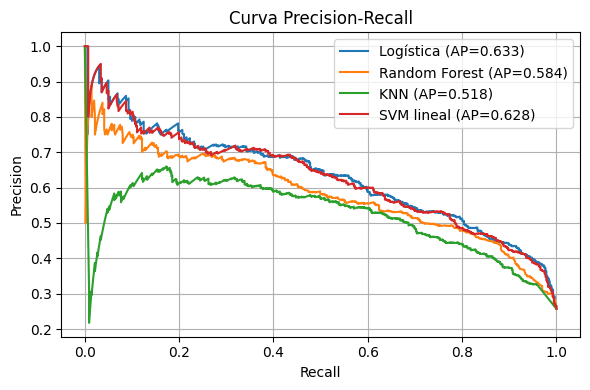

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

def prob_pred(model_or_pipe, X):
    # predict_proba si existe; si no, decision_function -> min-max a [0,1]
    if hasattr(model_or_pipe, "predict_proba"):
        return model_or_pipe.predict_proba(X)[:,1]
    if hasattr(model_or_pipe, "decision_function"):
        s = model_or_pipe.decision_function(X)
        s = (s - s.min()) / (s.max() - s.min() + 1e-12)
        return s
    return model_or_pipe.predict(X)

pairs = [
    ("Logística",     pipe_log),
    ("Random Forest", pipe_rf),
    ("KNN",           pipe_knn),
    ("SVM lineal",    pipe_svm)
]
probas = {name: prob_pred(model, X_test) for name, model in pairs}

# ROC
plt.figure(figsize=(6,4))
for name, p in probas.items():
    fpr, tpr, _ = roc_curve(y_test, p)
    auc = roc_auc_score(y_test, p)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.title("Curva ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.tight_layout()
plt.show()

# PR
plt.figure(figsize=(6,4))
for name, p in probas.items():
    prec, rec, _ = precision_recall_curve(y_test, p)
    ap = average_precision_score(y_test, p)
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
plt.title("Curva Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()


### 5.3 Variables más relevantes

In [22]:
# Coeficientes – Logística
model_log = pipe_log.named_steps['clf']
coef_log = (pd.DataFrame({
    "Variable": X_train.columns,
    "Coef_Logistica": model_log.coef_[0]
}).sort_values("Coef_Logistica", ascending=False))
coef_log.head(15)


,Variable,Coef_Logistica
14,InternetService_Fiber optic,0.831569
1,Charges.Total,0.624388
27,StreamingMovies_Yes,0.296375
25,StreamingTV_Yes,0.272034
30,MultipleLines_Yes,0.224480
7,PaperlessBilling_Yes,0.189615
9,PaymentMethod_Electronic check,0.155254
21,DeviceProtection_Yes,0.091799
2,SeniorCitizen,0.076990
28,PhoneService_Yes,0.027647


In [23]:
# Importancia – Random Forest
imp_rf = (pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia_RF": pipe_rf.named_steps['clf'].feature_importances_
}).sort_values("Importancia_RF", ascending=False))
imp_rf.head(15)

,Variable,Importancia_RF
1,Charges.Total,0.167348
3,tenure,0.150516
4,Cuentas_Diarias,0.131039
0,Charges.Monthly,0.131038
9,PaymentMethod_Electronic check,0.037476
14,InternetService_Fiber optic,0.037248
6,Contract_Two year,0.028244
11,gender_Male,0.026319
23,TechSupport_Yes,0.023151
7,PaperlessBilling_Yes,0.023073



## 6) Conclusiones e Insights
- **Contrato Month-to-month** y **cargos mensuales altos** suelen asociarse a mayor churn; mayor **tenure** y **gasto acumulado** tienden a retener.
- Para el **negocio**: migrar a contratos largos, ajustar pricing para ARPU alto, bundles con valor (seguridad/soporte), y campañas proactivas guiadas por el **score** del modelo.
